# demographics_us_data.ipynb

Draw charts of aggregated COVID-19 statistics over time for the United States, broken down according to various demographic metrics.

Inputs:
* `outputs/us_counties_clean.feather`: The contents of `outputs/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)
* `outputs/dates.feather`: Dates that go with the points in the time series in `outputs/us_counties_clean.feather`, produced by [clean_us_data.ipynb](./clean_us_data.ipynb).
* `outputs/us_counties_income.csv`: Income statistics by county for the united states, produced from U.S. Census Bureau raw data by [etl_us_census.ipynb](./etl_us_census.ipynb)

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Size of the line charts in this notebook, in inches
FIGSIZE = (13, 8)


# Read in the time series data

In [2]:
# Read time series data from the binary file that clean_us_data.ipynb produces
dates_file = os.path.join(_OUTPUTS_DIR, "dates.feather")
cases_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.feather")
cases = pd.read_feather(cases_file).set_index("FIPS")
dates = pd.read_feather(dates_file)["date"].to_numpy()

# Drop columns we don't use in this notebook
cases = cases[["State", "County", "Population", "Confirmed", "Deaths", "Confirmed_7_Days", "Deaths_7_Days"]]

# Break out final numbers as a separate column
cases["Confirmed_Total"] = cases["Confirmed"].to_numpy()[:,-1]
cases["Deaths_Total"] = cases["Deaths"].to_numpy()[:,-1]

# Normalize by population
cases["Confirmed_per_100_7_Days"] = cases["Confirmed_7_Days"] / cases["Population"]
cases["Deaths_per_100_7_Days"] = cases["Deaths_7_Days"] / cases["Population"]
cases["Confirmed_per_100_Total"] = cases["Confirmed_Total"] / cases["Population"]
cases["Deaths_per_100_Total"] = cases["Deaths_Total"] / cases["Population"]

# Rename columns to make the dataframe easier to view
cases = cases.rename(columns={
    "Confirmed_7_Days": "Confirmed 7_Days",
    "Deaths_7_Days": "Deaths 7_Days",
    "Confirmed_Total": "Confirmed Total",
    "Deaths_Total": "Deaths Total",
    "Confirmed_per_100_7_Days": "Confirmed per_100 7_Days",
    "Deaths_per_100_7_Days": "Deaths per_100 7_Days",
    "Confirmed_per_100_Total": "Confirmed per_100 Total",
    "Deaths_per_100_Total": "Deaths per_100 Total",
})


cases.head()

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,Deaths per_100 7_Days,Confirmed per_100 Total,Deaths per_100 Total
FIPS,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,0.000054,0.047146,0.000698
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,0.000000,0.037042,0.000376
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,0.000041,0.047031,0.000405
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0,1142,17,0.006654,0.000000,0.050996,0.000759
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2,2763,36,0.003268,0.000035,0.047781,0.000623


In [3]:
# Cut off the "almost all zeros" sections at the beginning of each time series
ALL_TS_COLS = ["Confirmed", "Deaths"]
min_confirmed = 100
first_time_above_min = np.argmax(np.max(cases["Confirmed"].array, axis=0) >= min_confirmed)

print(f"Dropping the first {first_time_above_min} elements of each time series.")

for ts_col_name in ALL_TS_COLS:
    cases[ts_col_name] = cases[ts_col_name].array[:,first_time_above_min:]

# Update our dates list too.
dates = dates[first_time_above_min:]

cases

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,Deaths per_100 7_Days,Confirmed per_100 Total,Deaths per_100 Total
FIPS,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,0.000054,0.047146,0.000698
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,0.000000,0.037042,0.000376
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,0.000041,0.047031,0.000405
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0,1142,17,0.006654,0.000000,0.050996,0.000759
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2,2763,36,0.003268,0.000035,0.047781,0.000623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,438,2,1548,6,0.010344,0.000047,0.036559,0.000142
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,241,0,1433,2,0.010271,0.000000,0.061072,0.000085
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,190,0,950,4,0.009394,0.000000,0.046969,0.000198


# Part 1: Population

Break down counties according to deciles of population. Graph the progression of the pandemic for each decile.

## Data Prep

In [4]:
# Break out demographic information into a third dataframe, again on
# the same index as the `cases` dataframe.
population_quantiles = cases["Population"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
population = cases[["State", "County", "Population"]].copy()
population["Population_Bin"] = pd.cut(population["Population"], 
                                        bins=([0.0] + population_quantiles.to_list()))
population

,State,County,Population,Population_Bin
FIPS,,,,
1001,Alabama,Autauga,55869,"(54018.7, 94275.6]"
1003,Alabama,Baldwin,223234,"(213707.3, 10039107.0]"
1005,Alabama,Barbour,24686,"(18693.0, 25726.0]"
1007,Alabama,Bibb,22394,"(18693.0, 25726.0]"
1009,Alabama,Blount,57826,"(54018.7, 94275.6]"
...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"(36743.0, 54018.7]"
56039,Wyoming,Teton,23464,"(18693.0, 25726.0]"
56041,Wyoming,Uinta,20226,"(18693.0, 25726.0]"


In [5]:
# Group all the time series by decile of population
cases_with_bin = cases.copy()
cases_with_bin["Population_Bin"] = population["Population_Bin"]

# TODO: Replace outliers with interpolated values before aggregating.

series_by_pop = cases_with_bin.groupby("Population_Bin").aggregate({
    "Population": "sum",
    "Confirmed": "sum",
    "Deaths" : "sum",
})

# Use the total populations to compute aggregated normalized time series
series_by_pop["Confirmed_per_100"] = 100.0 * series_by_pop["Confirmed"] / series_by_pop["Population"].values.reshape(-1,1)
series_by_pop["Deaths_per_100"] = 100.0 * series_by_pop["Deaths"] / series_by_pop["Population"].values.reshape(-1,1)

series_by_pop

,Population,Confirmed,Deaths,Confirmed_per_100,Deaths_per_100
Population_Bin,,,,,
"(0.0, 4992.2]",872420,[ 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 1...,[0. 0. 0. 0. 0....
"(4992.2, 8808.4]",2184561,[ 0 2 2 3 3 3 ...,[ 0 0 0 0 0 0 0 0 0 ...,[0.00000000e+00 9.15515749e-05 9.15515749e-05 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(8808.4, 13335.6]",3456224,[ 0 1 1 2 3 4 ...,[ 0 0 0 0 0 0 0 0 0 ...,[0.00000000e+00 2.89333099e-05 2.89333099e-05 5...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(13335.6, 18693.0]",5000037,[ 1 16 19 20 24 26 ...,[ 0 0 0 0 0 0 0 0 0 ...,[1.99998520e-05 3.19997632e-04 3.79997188e-04 3...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(18693.0, 25726.0]",6934301,[ 2 6 6 9 14 14 ...,[ 0 0 0 0 0 0 1 1 1 ...,[2.88421284e-05 8.65263853e-05 8.65263853e-05 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(25726.0, 36743.0]",9707534,[ 3 3 5 11 15 16 ...,[ 0 0 0 0 0 0 0 1 1 ...,[3.09038320e-05 3.09038320e-05 5.15063867e-05 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(36743.0, 54018.7]",13857842,[ 5 8 9 11 23 29 ...,[ 0 0 0 0 0 0 0 0 0 ...,[3.60806538e-05 5.77290461e-05 6.49451769e-05 7...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(54018.7, 94275.6]",22136348,[ 18 26 37 63 96 105 1...,[ 0 0 0 0 1 1 2 ...,[8.13142258e-05 1.17453882e-04 1.67145909e-04 2...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(94275.6, 213707.3]",44626025,[ 36 60 84 128 171 19...,[ 2 3 3 4 4 4 4 ...,[8.06704160e-05 1.34450693e-04 1.88230971e-04 2...,[4.48168978e-06 6.72253466e-06 6.72253466e-06 8...


## Code for Drawing Graphs in this Notebook

In [6]:
# Define a function to plot one time series from the `series_by_pop` 
# dataframe or anything similar

# Globally adjust the font size for matplotlib.
plt.rcParams.update({'font.size': 14})

_MATPLOTLIB_FIGSIZE=(14, 7)

def draw_plot_matplotlib(summary_df: pd.DataFrame, summary_descr: str,
              col_name: str, col_descr: str,
              use_int_bin_labels: bool = True):
    plt.figure(figsize=_MATPLOTLIB_FIGSIZE)
    for i in range(len(summary_df.index)):
        bin_interval = summary_df.index[i]
        if use_int_bin_labels:
            bin_name = f"{int(bin_interval.left)}-{int(bin_interval.right)}"
        else:
            bin_name = f"{bin_interval.left}-{bin_interval.right}"
        color_interval = 1.0 / len(summary_df.index)
    
        color = (i * color_interval, 0, (len(summary_df.index) - i) * color_interval)

        x_values = [pd.Timestamp(d) for d in dates]
        y_values = summary_df.iloc[i][col_name]._tensor
        
        plt.plot(x_values, y_values, c=color, label=bin_name, 
                 alpha=0.7, linewidth=4.0)
    plt.title(f"{col_descr} by {summary_descr}")
    plt.legend()
    plt.show()

# Plotly version, currently not used because it requires a JupyterLab
# extension to run.
def draw_plot_plotly(summary_df: pd.DataFrame, summary_descr: str,
              col_name: str, col_descr: str):
    import plotly.graph_objects as go
    fig = go.Figure()
    
    for i in range(len(summary_df.index)):
        bin_interval = summary_df.index[i]
        bin_name = f"{int(bin_interval.left)}-{int(bin_interval.right)}"
        color_interval = 255 / len(summary_df.index)
    
        color = f"rgb({i * color_interval}, 0, {(len(summary_df.index) - i) * color_interval})"

        x_values = [pd.Timestamp(d) for d in dates]
        y_values = summary_df.iloc[i][col_name]._tensor
        
        fig.add_trace(go.Scatter(x=x_values, y=y_values,
                                 mode="lines+markers",
                                 name=bin_name,
                                 marker_color=color,
                                 line_color=color))
    fig.update_layout(
        title=f"{col_descr} by {summary_descr}",
        xaxis_title="Date",
        yaxis_title=f"{col_descr} (log scale)",
        #yaxis_type="log",
        legend_title=summary_descr)
    fig.show()

    
draw_plot = draw_plot_matplotlib

## Graph: Confirmed Cases by County Population

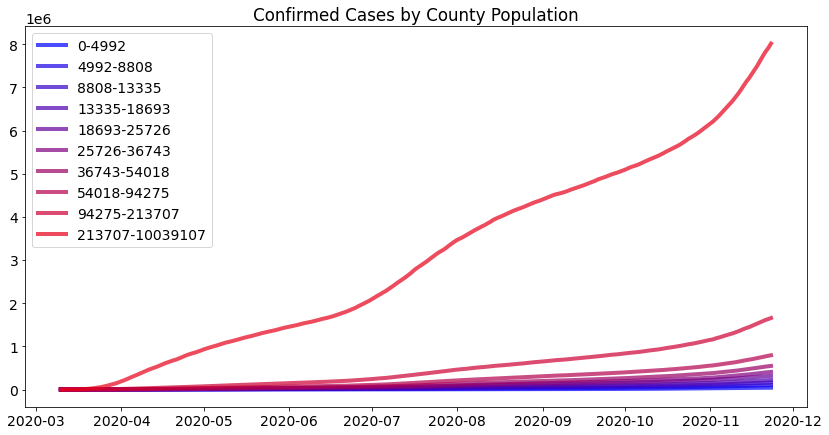

In [7]:
draw_plot(series_by_pop, "County Population", "Confirmed", "Confirmed Cases")

## Graph: Confirmed Cases per 100 Residents by County Population

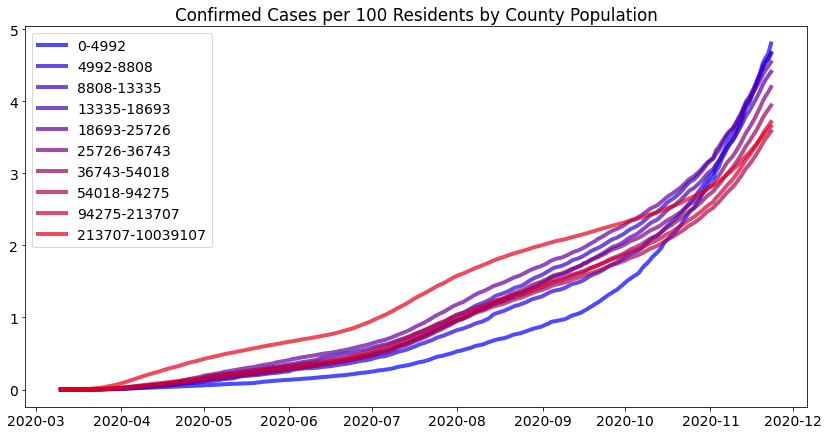

In [8]:
draw_plot(series_by_pop, "County Population", "Confirmed_per_100", "Confirmed Cases per 100 Residents")

## Graph: Deaths by County Population

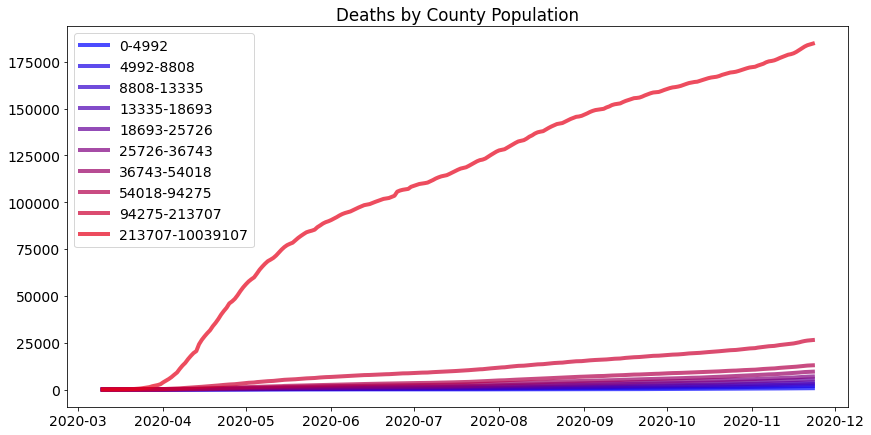

In [9]:
draw_plot(series_by_pop, "County Population", "Deaths", "Deaths")

## Graph: Deaths per 100 Residents by County Population

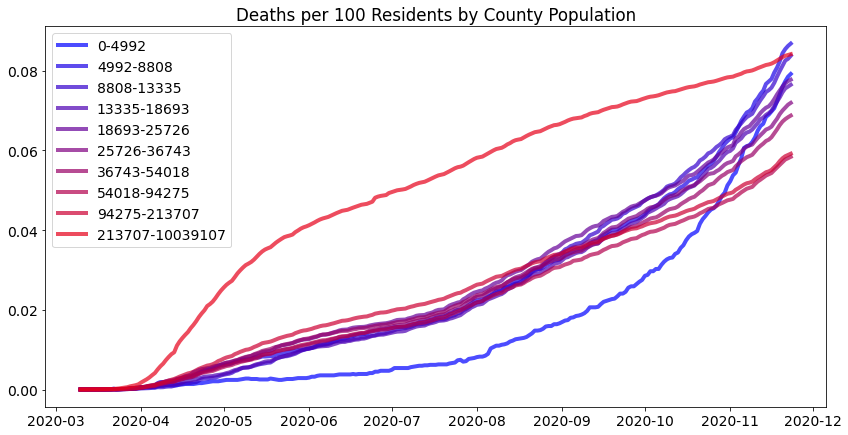

In [10]:
draw_plot(series_by_pop, "County Population", "Deaths_per_100", "Deaths per 100 Residents")

## Scatter Plot: Confirmed Cases per 100 Residents vs. County Population

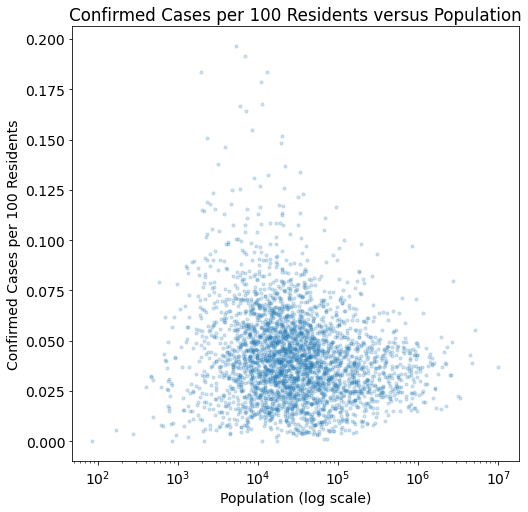

In [11]:
_MATPLOTLIB_SCATTERSIZE=(8, 8)

def draw_scatter(x, y, x_name: str, y_name: str,
                 logx=False):
    plt.figure(figsize=_MATPLOTLIB_SCATTERSIZE)
    plt.scatter(x, y,
                alpha=0.2, 
                s=10, # Marker size
               )
    plt.ylabel(y_name)
    if logx:
        plt.xscale("log")
        plt.xlabel(f"{x_name} (log scale)")
    else:
        plt.xlabel(x_name)
    plt.title(f"{y_name} versus {x_name}")
    plt.show()
    
draw_scatter(cases["Population"], cases["Confirmed per_100 Total"],
             "Population", "Confirmed Cases per 100 Residents",
             logx=True)

## Scatter Plot: Deaths per 100 Residents vs. County Population

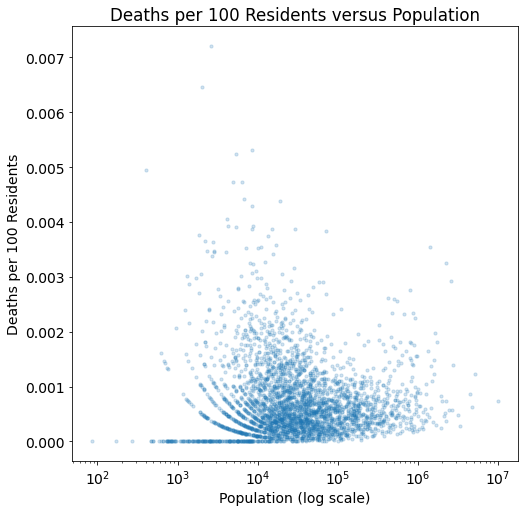

In [12]:
draw_scatter(cases["Population"], cases["Deaths per_100 Total"],
             "Population", "Deaths per 100 Residents", logx=True)

# Part 2: Income

Join the time series data with U.S. Census Bureau data on income statistics by county.
Break counties into deciles by median income and graph the progression of the pandemic for each decile.

## Data Prep

In [13]:
# Workaround to prevent Jupyter displaying Pandas column headers as LaTeX equations
# See https://stackoverflow.com/questions/39948861/how-to-avoid-markdown-typesetting-of-signs-in-jupyter-output
pd.options.display.html.use_mathjax = False

# Read in income statistics by county.
income_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_income.csv")
income = pd.read_csv(income_data_file).set_index("FIPS")
income

,County,State,"Percent Less than $10,000","Percent $10,000 to $14,999","Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,
1001,Autauga,Alabama,7.1,5.8,10.1,7.9,11.9,18.1,14.1,16.6,5.5,3.1,58786.0,75515.0
1003,Baldwin,Alabama,5.4,5.2,9.2,11.0,13.5,19.3,12.3,13.6,5.5,5.1,55962.0,77212.0
1005,Barbour,Alabama,13.3,8.9,16.5,12.1,14.2,14.3,8.8,9.1,1.3,1.4,34186.0,47909.0
1007,Bibb,Alabama,6.4,8.2,12.9,11.1,15.0,16.7,14.6,10.2,3.1,1.7,45340.0,58529.0
1009,Blount,Alabama,8.4,5.6,11.4,12.6,13.1,20.9,11.9,10.6,3.5,1.9,48695.0,60646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72145,Vega Baja Municipio,Puerto Rico,28.9,12.8,17.6,13.3,10.0,11.5,3.4,1.7,0.5,0.4,19096.0,27927.0
72147,Vieques Municipio,Puerto Rico,28.8,19.8,16.7,13.8,12.5,6.2,0.4,1.7,0.0,0.0,15539.0,22635.0
72149,Villalba Municipio,Puerto Rico,24.3,14.0,20.0,14.9,13.2,9.2,2.5,1.5,0.2,0.2,19855.0,29895.0


In [14]:
# Outer join the income data with our time series
cases_with_income = cases.join(income, rsuffix="_Census", how="left")
cases_with_income

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,...,"Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,...,10.1,7.9,11.9,18.1,14.1,16.6,5.5,3.1,58786.0,75515.0
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,...,9.2,11.0,13.5,19.3,12.3,13.6,5.5,5.1,55962.0,77212.0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,...,16.5,12.1,14.2,14.3,8.8,9.1,1.3,1.4,34186.0,47909.0
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0,1142,17,0.006654,...,12.9,11.1,15.0,16.7,14.6,10.2,3.1,1.7,45340.0,58529.0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2,2763,36,0.003268,...,11.4,12.6,13.1,20.9,11.9,10.6,3.5,1.9,48695.0,60646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,438,2,1548,6,0.010344,...,8.2,6.1,10.7,17.8,16.4,21.6,6.4,4.2,73008.0,84961.0
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,241,0,1433,2,0.010271,...,6.3,4.7,9.4,17.6,15.1,19.9,6.9,15.7,83831.0,128868.0
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,190,0,950,4,0.009394,...,9.5,8.5,14.6,19.0,13.9,15.5,7.3,1.8,58235.0,71005.0


In [15]:
# How many counties do we not have income data for?
cases_with_income[cases_with_income["Median income (dollars)"].isna()]

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,...,"Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,,,,,,,,
35039,New Mexico,Rio Arriba,38921,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,330,2,1118,21,0.008479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Since we're only missing one county's income stats, just filter out that county.
cases_with_income = cases_with_income[~cases_with_income["Median income (dollars)"].isna()]
cases_with_income

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,...,"Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,...,10.1,7.9,11.9,18.1,14.1,16.6,5.5,3.1,58786.0,75515.0
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,...,9.2,11.0,13.5,19.3,12.3,13.6,5.5,5.1,55962.0,77212.0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,...,16.5,12.1,14.2,14.3,8.8,9.1,1.3,1.4,34186.0,47909.0
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0,1142,17,0.006654,...,12.9,11.1,15.0,16.7,14.6,10.2,3.1,1.7,45340.0,58529.0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2,2763,36,0.003268,...,11.4,12.6,13.1,20.9,11.9,10.6,3.5,1.9,48695.0,60646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,438,2,1548,6,0.010344,...,8.2,6.1,10.7,17.8,16.4,21.6,6.4,4.2,73008.0,84961.0
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,241,0,1433,2,0.010271,...,6.3,4.7,9.4,17.6,15.1,19.9,6.9,15.7,83831.0,128868.0
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,190,0,950,4,0.009394,...,9.5,8.5,14.6,19.0,13.9,15.5,7.3,1.8,58235.0,71005.0


In [17]:
# Label counties by decile of medium income.
median_income_quantiles = cases_with_income["Median income (dollars)"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
median_income = cases[["State", "County", "Population"]].copy()
median_income["Median_Income_Bin"] = pd.cut(cases_with_income["Median income (dollars)"], 
                                        bins=([0.0] + median_income_quantiles.to_list()))
median_income

,State,County,Population,Median_Income_Bin
FIPS,,,,
1001,Alabama,Autauga,55869,"(55683.0, 59898.0]"
1003,Alabama,Baldwin,223234,"(55683.0, 59898.0]"
1005,Alabama,Barbour,24686,"(0.0, 36877.0]"
1007,Alabama,Bibb,22394,"(44000.0, 47063.0]"
1009,Alabama,Blount,57826,"(47063.0, 49888.0]"
...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"(67591.0, 136268.0]"
56039,Wyoming,Teton,23464,"(67591.0, 136268.0]"
56041,Wyoming,Uinta,20226,"(55683.0, 59898.0]"


In [18]:
# Group all the time series by decile of median income
cases_with_bin = cases.copy()
cases_with_bin["Median_Income_Bin"] = median_income["Median_Income_Bin"]

series_by_median_income = cases_with_bin.groupby("Median_Income_Bin").aggregate({
    "Population": "sum",
    "Confirmed": "sum",
    "Deaths" : "sum",
})

# Use the total populations to compute aggregated normalized time series
series_by_median_income["Confirmed_per_100"] = (
    100.0 * series_by_median_income["Confirmed"] / series_by_median_income["Population"].values.reshape(-1,1))
series_by_median_income["Deaths_per_100"] = (
    100.0 * series_by_median_income["Deaths"] / series_by_median_income["Population"].values.reshape(-1,1))

series_by_median_income

,Population,Confirmed,Deaths,Confirmed_per_100,Deaths_per_100
Median_Income_Bin,,,,,
"(0.0, 36877.0]",5753313,[ 0 2 2 3 3 3 ...,[ 0 0 0 0 0 0 0 0 0 ...,[0.00000000e+00 3.47625794e-05 3.47625794e-05 5...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(36877.0, 40893.0]",11023413,[ 5 11 24 41 90 112 1...,[ 0 0 0 0 1 2 4 ...,[4.53580030e-05 9.97876066e-05 2.17718414e-04 3...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(40893.0, 44000.0]",12273653,[ 3 4 5 10 13 16 ...,[ 0 0 0 0 0 0 0 ...,[2.44426007e-05 3.25901343e-05 4.07376679e-05 8...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(44000.0, 47063.0]",18838517,[ 6 8 16 25 35 45 ...,[ 0 0 1 2 2 2 3 ...,[3.18496408e-05 4.24661878e-05 8.49323755e-05 1...,[0.00000000e+00 0.00000000e+00 5.30827347e-06 1...
"(47063.0, 49888.0]",22923956,[ 15 25 24 40 69 73 1...,[ 0 0 0 0 0 0 0 ...,[6.54337323e-05 1.09056220e-04 1.04693972e-04 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(49888.0, 52583.0]",22776344,[ 8 19 29 43 71 84 1...,[ 0 0 0 0 0 0 1 ...,[3.51241622e-05 8.34198851e-05 1.27325088e-04 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(52583.0, 55683.0]",30702299,[ 18 26 36 49 80 9...,[ 2 3 3 3 3 4 4 ...,[5.86275314e-05 8.46842121e-05 1.17255063e-04 1...,[6.51417016e-06 9.77125524e-06 9.77125524e-06 9...
"(55683.0, 59898.0]",35189201,[ 33 55 79 130 191 24...,[ 0 0 0 0 1 1 3 ...,[9.37787704e-05 1.56297951e-04 2.24500693e-04 3...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(59898.0, 67591.0]",74790499,[ 116 174 227 323 480 53...,[ 1 3 4 5 4 6 7 1...,[1.55099914e-04 2.32649872e-04 3.03514488e-04 4...,[1.33706823e-06 4.01120469e-06 5.34827291e-06 6...


## Graph: Confirmed Cases by Median Income of County

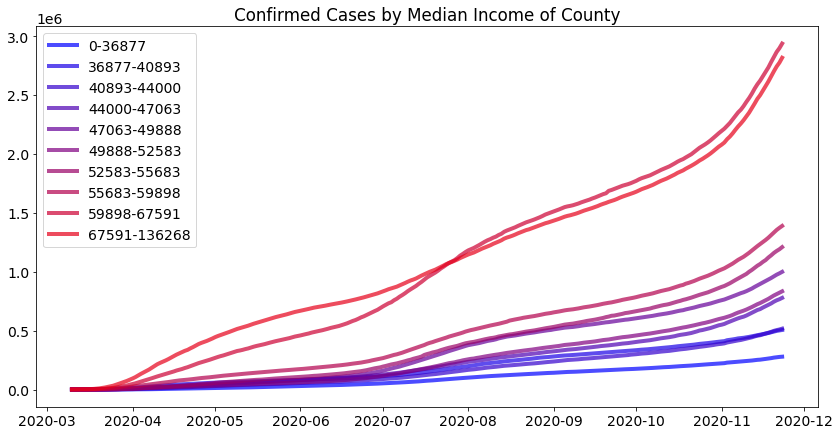

In [19]:
draw_plot(series_by_median_income, "Median Income of County", "Confirmed", "Confirmed Cases")

## Graph: Confirmed Cases per 100 Residents by Median Income of County

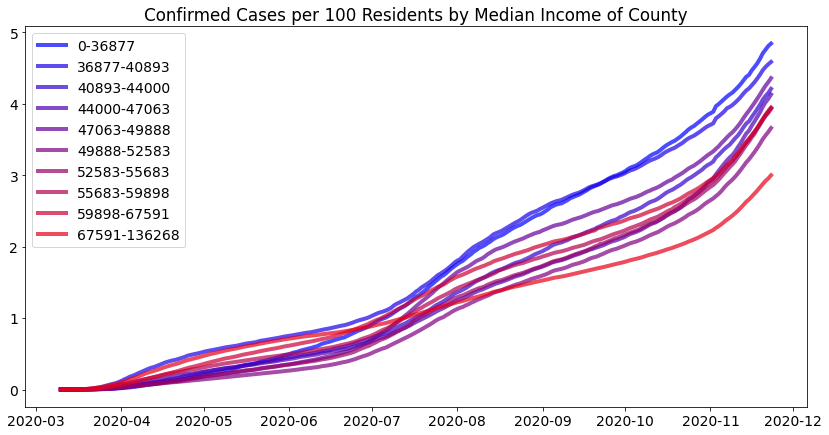

In [20]:
draw_plot(series_by_median_income, "Median Income of County", "Confirmed_per_100", "Confirmed Cases per 100 Residents")

## Graph: Deaths by Median Income of County

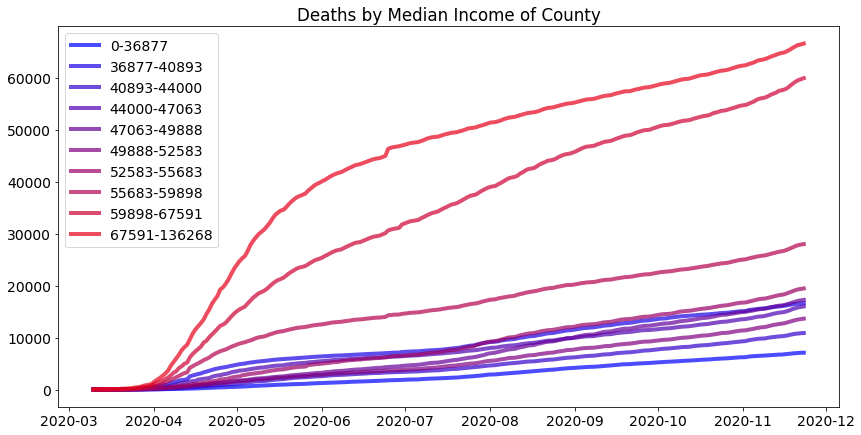

In [21]:
draw_plot(series_by_median_income, "Median Income of County", "Deaths", "Deaths")

## Graph: Deaths per 100 Residents by Median Income of County

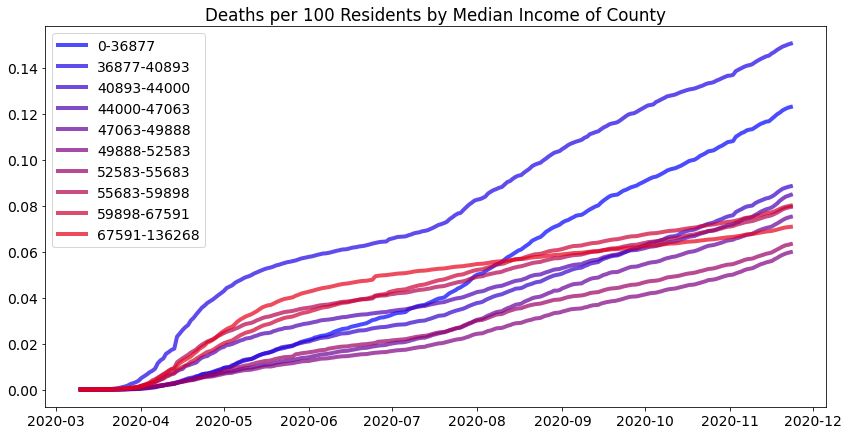

In [22]:
draw_plot(series_by_median_income, "Median Income of County", "Deaths_per_100", "Deaths per 100 Residents")

## Scatter Plot: Confirmed Cases per 100 Residents vs. Median Income of County

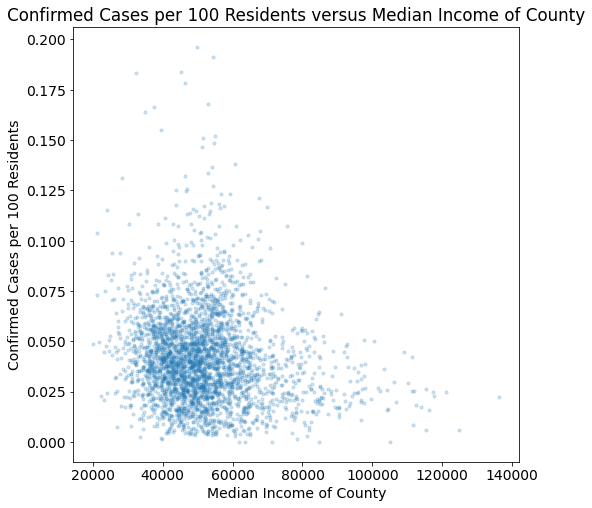

In [23]:
draw_scatter(cases_with_income["Median income (dollars)"], 
             cases_with_income["Confirmed per_100 Total"],
             "Median Income of County", "Confirmed Cases per 100 Residents")

## Scatter Plot: Deaths per 100 Residents vs. Median Income of County

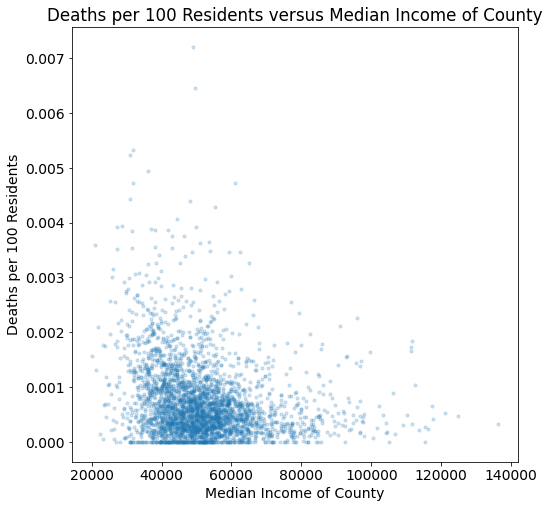

In [24]:
draw_scatter(cases_with_income["Median income (dollars)"], 
             cases_with_income["Deaths per_100 Total"],
             "Median Income of County", "Deaths per 100 Residents")

# Part 3: 2016 Election Results

## Data Prep

In [25]:
# 2016 election results by county, from
# https://github.com/tonmcg/US_County_Level_Election_Results_08-16
election_results_url = \
"https://github.com/tonmcg/US_County_Level_Election_Results_08-16/raw/master/" + \
"2016_US_County_Level_Presidential_Results.csv"
election_by_county = pd.read_csv(election_results_url)
election_by_county

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2060
...,...,...,...,...,...,...,...,...,...,...,...
3136,3136,3233.0,12153.0,16661.0,0.194046,0.729428,"8,920",53.54%,WY,Sweetwater County,56037
3137,3137,7313.0,3920.0,12176.0,0.600608,0.321945,"3,393",27.87%,WY,Teton County,56039
3138,3138,1202.0,6154.0,8053.0,0.149261,0.764187,"4,952",61.49%,WY,Uinta County,56041
3139,3139,532.0,2911.0,3715.0,0.143203,0.783580,"2,379",64.04%,WY,Washakie County,56043


In [26]:
# Strip out unneeded columns and index for joining
election_by_county["FIPS"] = election_by_county["combined_fips"]
election_by_county.rename(columns={"per_gop": "gop_fraction"}, inplace=True)
election_by_county = election_by_county[["gop_fraction", "votes_gop", "total_votes", "FIPS"]].set_index("FIPS")
election_by_county

,gop_fraction,votes_gop,total_votes
FIPS,,,
2013,0.528870,130413.0,246588.0
2016,0.528870,130413.0,246588.0
2020,0.528870,130413.0,246588.0
2050,0.528870,130413.0,246588.0
2060,0.528870,130413.0,246588.0
...,...,...,...
56037,0.729428,12153.0,16661.0
56039,0.321945,3920.0,12176.0
56041,0.764187,6154.0,8053.0


In [27]:
# Outer join the election data with our time series
cases_with_election = cases.join(election_by_county, rsuffix="_Election", how="left")
cases_with_election.head(3)

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,Deaths per_100 7_Days,Confirmed per_100 Total,Deaths per_100 Total,gop_fraction,votes_gop,total_votes
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,0.000054,0.047146,0.000698,0.734358,18110.0,24661.0
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,0.000000,0.037042,0.000376,0.773515,72780.0,94090.0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,0.000041,0.047031,0.000405,0.522714,5431.0,10390.0


In [28]:
# How many counties weren't in our election data?
cases_with_election[cases_with_election["votes_gop"].isna()]

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,Deaths per_100 7_Days,Confirmed per_100 Total,Deaths per_100 Total,gop_fraction,votes_gop,total_votes
FIPS,,,,,,,,,,,,,,,,
2158,Alaska,Kusilvak,8314,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,34,0,391,0,0.004089,0.000000,0.047029,0.000000,NaN,NaN,NaN
15005,Hawaii,Kalawao,86,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
46102,South Dakota,Oglala Lakota,14177,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,132,7,1539,20,0.009311,0.000494,0.108556,0.001411,NaN,NaN,NaN


In [29]:
# Only 3 counties, and they have no cases (yet). Just drop them for now, then convert
# the integer columns back to integers (Pandas outer join made them floats).
cases_with_election = cases_with_election[~cases_with_election["votes_gop"].isna()]
cases_with_election["votes_gop"] = cases_with_election["votes_gop"].astype(int)
cases_with_election["total_votes"] = cases_with_election["total_votes"].astype(int)
cases_with_election["Confirmed"] = tp.TensorArray(cases_with_election["Confirmed"].array.astype(int))
cases_with_election["Deaths"] = tp.TensorArray(cases_with_election["Deaths"].array.astype(int))
cases_with_election.head(3)

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,Deaths per_100 7_Days,Confirmed per_100 Total,Deaths per_100 Total,gop_fraction,votes_gop,total_votes
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,0.000054,0.047146,0.000698,0.734358,18110,24661
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,0.000000,0.037042,0.000376,0.773515,72780,94090
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,0.000041,0.047031,0.000405,0.522714,5431,10390


In [30]:
# Compute quantiles by fraction of each county's vote for the GOP presidential candidate
gop_fraction_quantiles = cases_with_election["gop_fraction"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cases_with_election["GOP_Fraction_Bin"] = pd.cut(
    cases_with_election["gop_fraction"], bins=([0.0] + gop_fraction_quantiles.to_list()))
cases_with_election

,State,County,Population,Confirmed,Deaths,Confirmed 7_Days,Deaths 7_Days,Confirmed Total,Deaths Total,Confirmed per_100 7_Days,Deaths per_100 7_Days,Confirmed per_100 Total,Deaths per_100 Total,gop_fraction,votes_gop,total_votes,GOP_Fraction_Bin
FIPS,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3,2634,39,0.002739,0.000054,0.047146,0.000698,0.734358,18110,24661,"(0.702, 0.735]"
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0,8269,84,0.002567,0.000000,0.037042,0.000376,0.773515,72780,94090,"(0.767, 0.809]"
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1,1161,10,0.001256,0.000041,0.047031,0.000405,0.522714,5431,10390,"(0.512, 0.574]"
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0,1142,17,0.006654,0.000000,0.050996,0.000759,0.769662,6733,8748,"(0.767, 0.809]"
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2,2763,36,0.003268,0.000035,0.047781,0.000623,0.898519,22808,25384,"(0.809, 0.953]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,438,2,1548,6,0.010344,0.000047,0.036559,0.000142,0.729428,12153,16661,"(0.702, 0.735]"
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,241,0,1433,2,0.010271,0.000000,0.061072,0.000085,0.321945,3920,12176,"(0.0, 0.416]"
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,190,0,950,4,0.009394,0.000000,0.046969,0.000198,0.764187,6154,8053,"(0.735, 0.767]"


In [31]:
series_by_gop_fraction = cases_with_election.groupby("GOP_Fraction_Bin").aggregate({
    "Population": "sum",
    "Confirmed": "sum",
    "Deaths" : "sum",
})

# Use the total populations to compute aggregated normalized time series
series_by_gop_fraction["Confirmed_per_100"] = (
    100.0 * series_by_gop_fraction["Confirmed"] / series_by_gop_fraction["Population"].values.reshape(-1,1))
series_by_gop_fraction["Deaths_per_100"] = (
    100.0 * series_by_gop_fraction["Deaths"] / series_by_gop_fraction["Population"].values.reshape(-1,1))

series_by_gop_fraction

,Population,Confirmed,Deaths,Confirmed_per_100,Deaths_per_100
GOP_Fraction_Bin,,,,,
"(0.0, 0.416]",127933200,[ 619 879 1172 1565 2099 233...,[ 23 26 34 41 44 49 ...,[4.83846257e-04 6.87077318e-04 9.16103091e-04 1...,[1.79781323e-05 2.03231061e-05 2.65763695e-05 3...
"(0.416, 0.512]",74985761,[ 93 152 212 292 414 46...,[ 1 1 2 2 4 4 5 1...,[1.24023546e-04 2.02705151e-04 2.82720342e-04 3...,[1.33358652e-06 1.33358652e-06 2.66717304e-06 2...
"(0.512, 0.574]",34690582,[ 26 41 67 106 150 17...,[ 1 1 2 3 3 4 7 ...,[7.49482958e-05 1.18187697e-04 1.93135993e-04 3...,[2.88262676e-06 2.88262676e-06 5.76525352e-06 8...
"(0.574, 0.622]",25237850,[ 16 28 37 56 85 98 1...,[ 1 1 1 1 1 2 2 ...,[6.33968424e-05 1.10944474e-04 1.46605198e-04 2...,[3.96230265e-06 3.96230265e-06 3.96230265e-06 3...
"(0.622, 0.665]",19249387,[ 9 20 26 36 44 46 ...,[ 1 2 2 2 2 2 4 ...,[4.67547356e-05 1.03899412e-04 1.35069236e-04 1...,[5.19497062e-06 1.03899412e-05 1.03899412e-05 1...
"(0.665, 0.702]",12613670,[ 7 14 18 26 35 33 ...,[ 0 0 0 0 0 0 0 2 2 ...,[5.54953475e-05 1.10990695e-04 1.42702322e-04 2...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(0.702, 0.735]",12452727,[ 3 5 7 12 19 26 ...,[ 0 0 0 0 0 0 0 0 2 ...,[2.40911087e-05 4.01518479e-05 5.62125870e-05 9...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
"(0.735, 0.767]",9200041,[ 2 6 14 15 22 25 ...,[ 1 1 1 1 1 1 1 1 1 ...,[2.17390336e-05 6.52171007e-05 1.52173235e-04 1...,[1.08695168e-05 1.08695168e-05 1.08695168e-05 1...
"(0.767, 0.809]",7435357,[ 1 2 2 5 6 7 ...,[ 0 0 0 0 0 0 0 0 0 ...,[1.34492533e-05 2.68985067e-05 2.68985067e-05 6...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...


## Graph: Confirmed Cases by 2016 Presidential Vote

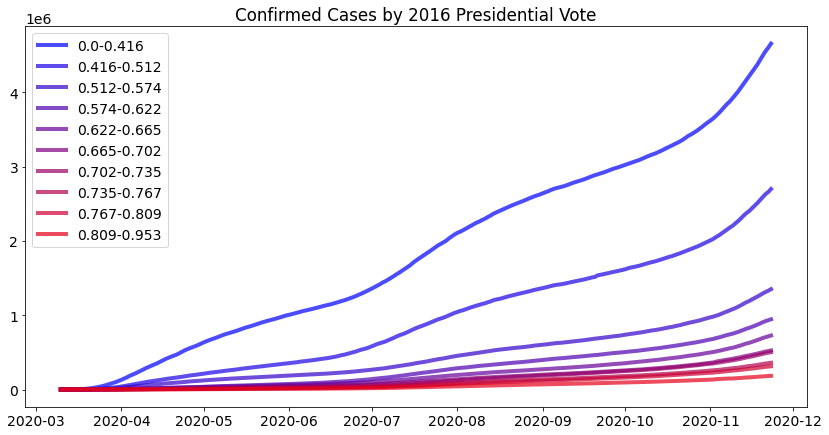

In [32]:
draw_plot(series_by_gop_fraction, "2016 Presidential Vote", "Confirmed", "Confirmed Cases", False)

## Graph: Confirmed Cases per 100 Residents by 2016 Presidential Vote

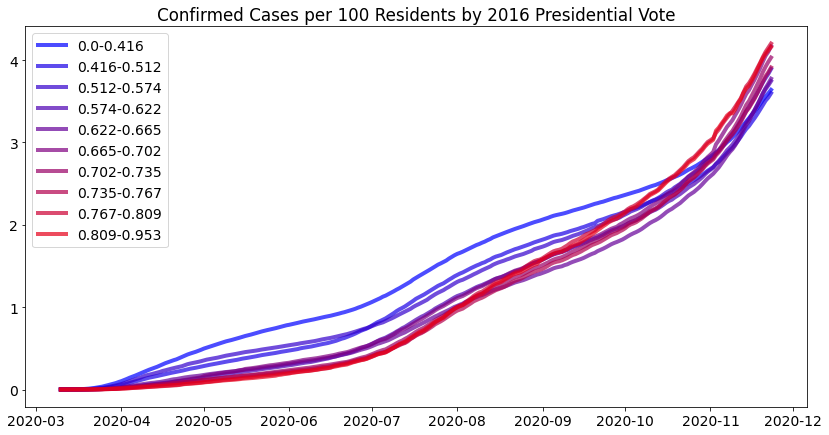

In [33]:
draw_plot(series_by_gop_fraction, "2016 Presidential Vote", "Confirmed_per_100", "Confirmed Cases per 100 Residents", False)

## Graph: Deaths by 2016 Presidential Vote

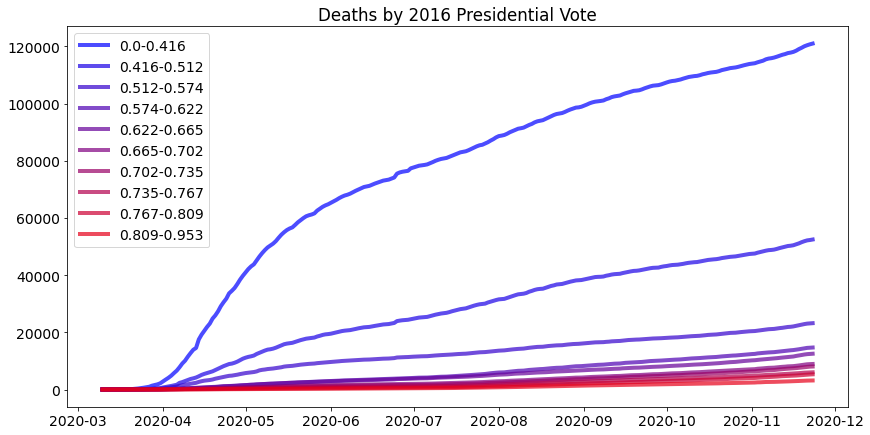

In [34]:
draw_plot(series_by_gop_fraction, "2016 Presidential Vote", "Deaths", "Deaths", False)

## Graph: Deaths per 100 Residents by 2016 Presidential Vote

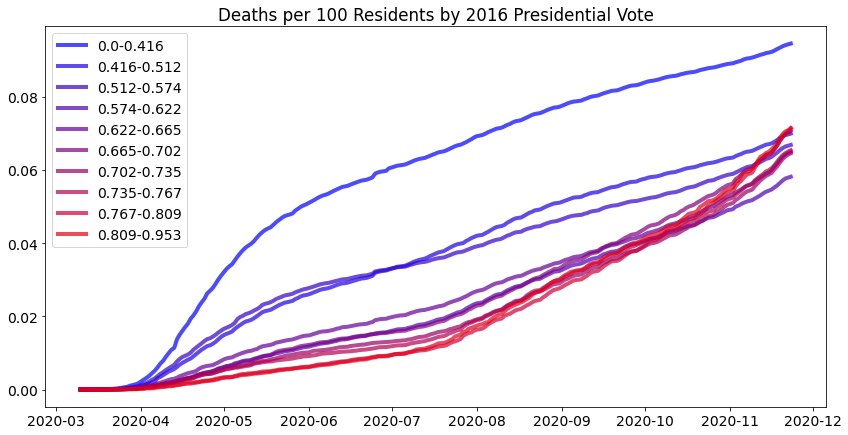

In [35]:
draw_plot(series_by_gop_fraction, "2016 Presidential Vote", "Deaths_per_100", "Deaths per 100 Residents", False)

## Scatter Plot: Confirmed Cases per 100 Residents vs. 2016 Presidential Vote

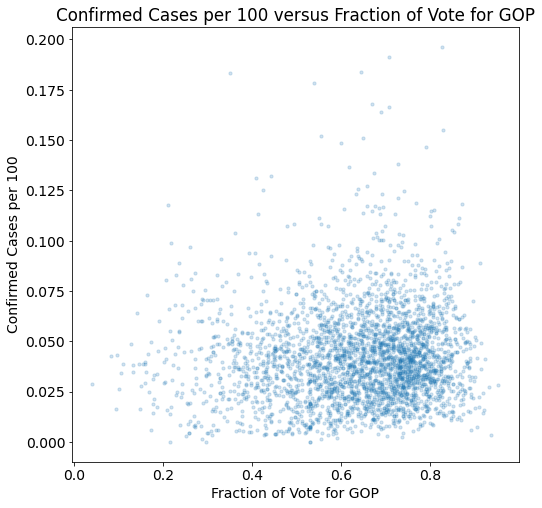

In [36]:
draw_scatter(cases_with_election["gop_fraction"], 
             cases_with_election["Confirmed per_100 Total"],
             "Fraction of Vote for GOP", "Confirmed Cases per 100")

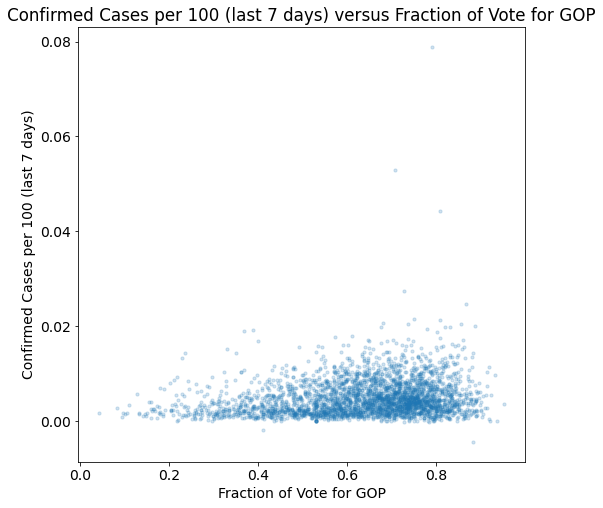

In [37]:
draw_scatter(cases_with_election["gop_fraction"], 
             cases_with_election["Confirmed per_100 7_Days"],
             "Fraction of Vote for GOP", "Confirmed Cases per 100 (last 7 days)")

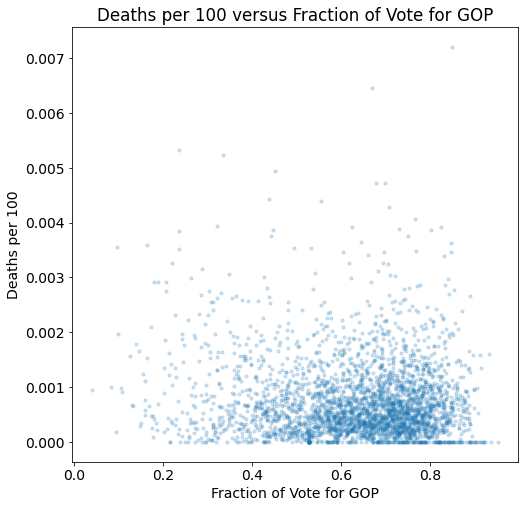

In [38]:
draw_scatter(cases_with_election["gop_fraction"], 
             cases_with_election["Deaths per_100 Total"],
             "Fraction of Vote for GOP", "Deaths per 100")